In [1]:
import datetime
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [5]:
#Подход 1: градиентный бустинг "в лоб"
#1. Считайте таблицу с признаками из файла features.csv
#Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

train = pd.read_csv('C:/Users/Юлия Витковская/Desktop/features.csv', index_col="match_id")
train.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [6]:
train.drop([
    "duration",
    "tower_status_radiant",
    "tower_status_dire",
    "barracks_status_radiant",
    "barracks_status_dire",
], axis=1, inplace=True)

In [7]:
#2. Проверьте выборку на наличие пропусков с помощью функции count(),
#которая для каждого столбца показывает число заполненных значений.
#Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски,
#и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

count_na = len(train) - train.count()
count_na[count_na > 0].sort_values(ascending=False) / len(train)

first_blood_player2            0.452402
radiant_flying_courier_time    0.282619
dire_flying_courier_time       0.268415
first_blood_player1            0.201100
first_blood_team               0.201100
first_blood_time               0.201100
dire_bottle_time               0.166029
radiant_bottle_time            0.161380
radiant_first_ward_time        0.018883
dire_first_ward_time           0.018780
radiant_courier_time           0.007117
dire_courier_time              0.006953
dtype: float64

In [8]:
#Обоснование пропусков:
#first_blood_player2 (второй игрок, причастный к событию) - первое убийство может быть совершено одним игроком, это достаточно частое явление и происходит в 45% случаев.
#radiant_flying_courier_time (время приобретения предмета "flying_courier") - в 28% случаев команда не покупает "flying_courier" в первые 5 минут игры.
#dire_flying_courier_time - аналогично radiant_flying_courier_time, процент почти тот же (26%).
#first_blood_time (игровое время первой крови) - в 20% случаев первой крови нет в первые 5 минут игры.
#first_blood_team (команда, совершившая первую кровь) - аналогично first_blood_time, процент совпадает (20%).
#first_blood_player1 (игрок, причастный к событию) - аналогично first_blood_time, процент совпадает (20%).
#dire_bottle_time (время первого приобретения командой предмета "bottle") - в 16% случаев команда не приобретает предмет "bottle" в первые 5 минут игры.
#radiant_bottle_time - аналогично dire_bottle_time, процент почти тот же (16%).
#radiant_first_ward_time (время установки командой первого "наблюдателя") - очень редкое явление, в 1% случаев команда не ставит "наблюдателя" в первые 5 минут игры.
#dire_first_ward_time - аналогично radiant_first_ward_time, процент почти тот же (1%).
#radiant_courier_time (время приобретения предмета "courier") - самое редкое явление, в 0.5% случаев команда не приобретает предмет "courier" в первые 5 минут игры.
#dire_courier_time - аналогично radiant_courier_time, процент почти тот же (0.5%).

In [9]:
#3. Замените пропуски на нули с помощью функции fillna().
train.fillna(0, inplace=True)

In [10]:
#4. Какой столбец содержит целевую переменную?
#Запишите его название.
X_train = train.drop("radiant_win", axis=1)
y_train = train["radiant_win"]

In [11]:
#5. Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями
#на имеющейся матрице "объекты-признаки".
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [1]:
def score_gb(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    scores = {}

    for n_estimators in [10, 20, 30, 50, 100, 250]:
        print(f"n_estimators={n_estimators}")
        model = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42)

        start_time = datetime.datetime.now()
        score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
        print(f"Score: {score:.3f}")
        print(f"Time elapsed: {datetime.datetime.now() - start_time}")

        scores[n_estimators] = score
        print()
        
    return pd.Series(scores)

NameError: name 'pd' is not defined

n_estimators=10
Score: 0.665
Time elapsed: 0:00:47.665637

n_estimators=20
Score: 0.682
Time elapsed: 0:01:06.960723

n_estimators=30
Score: 0.690
Time elapsed: 0:01:41.892038

n_estimators=50
Score: 0.697
Time elapsed: 0:02:47.403795

n_estimators=100
Score: 0.706
Time elapsed: 0:05:42.928252

n_estimators=250
Score: 0.716
Time elapsed: 0:17:37.164821



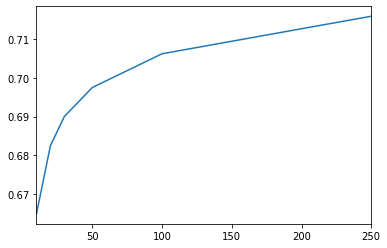

In [13]:
scores = score_gb(X_train, y_train)
scores.plot()

In [14]:
#Кросс-валидация для градиентного бустинга с 30 деревьями заняла 0:00:45. Показатель метрики качества AUC-ROC в таком случае равен 0.69.
#Увеличение количества деревьев также увеличивает показатель метрики AUC-ROC, приближая его к 0.72.
#Для достижения большего качества имеет смысл использовать более 30 деревьев.
#Для ускорения обучения можно использовать не всю выборку, а некоторое ее подмножество — например, половину объектов.
#Также можно уменьшить глубину деревьев (max_depth).

In [15]:
#Подход 2: логистическая регрессия
#1. Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией)
#с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга.
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

In [16]:
def score_lr(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    scores = {}

    for i in range(-5, 6):
        C = 10.0 ** i

        print(f"C={C}")
        model = LogisticRegression(C=C, random_state=42)

        start_time = datetime.datetime.now()
        score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
        print(f"Score: {score:.3f}")
        print(f"Time elapsed: {datetime.datetime.now() - start_time}")

        scores[i] = score
        print()

    return pd.Series(scores)

C=1e-05
Score: 0.695
Time elapsed: 0:02:16.494185

C=0.0001
Score: 0.711
Time elapsed: 0:00:06.632093

C=0.001
Score: 0.716
Time elapsed: 0:00:10.539427

C=0.01
Score: 0.717
Time elapsed: 0:00:12.275331

C=0.1
Score: 0.717
Time elapsed: 0:00:14.481870

C=1.0
Score: 0.717
Time elapsed: 0:00:17.164154

C=10.0
Score: 0.717
Time elapsed: 0:00:14.555709

C=100.0
Score: 0.717
Time elapsed: 0:00:16.430988

C=1000.0
Score: 0.717
Time elapsed: 0:00:14.190789

C=10000.0
Score: 0.717
Time elapsed: 0:00:15.820873

C=100000.0
Score: 0.717
Time elapsed: 0:00:16.275019



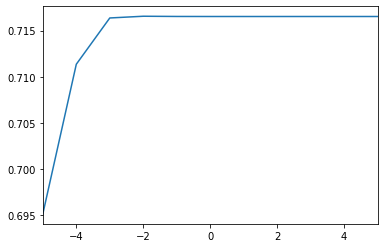

In [17]:
scores = score_lr(X_train, y_train)
scores.plot()

In [18]:
def print_best_lr_score(scores: pd.Series):
    best_iteration = scores.sort_values(ascending=False).head(1)
    best_C = 10.0 ** best_iteration.index[0]
    best_score = best_iteration.values[0]

    print(f"Наилучшее значение показателя AUC-ROC достигается при C = {best_C:.2f} и равно {best_score:.2f}.")

In [19]:
print_best_lr_score(scores)

Наилучшее значение показателя AUC-ROC достигается при C = 0.01 и равно 0.72.


In [20]:
#Это сравнимо с градиентным бустингом по 250 деревьям, при этом логистическая регрессия работает заметно быстрее.
#Отсутствие разницы с градиентным бустингом может говорить о том, что характер связи между данными фичами и целевой переменной -
#линейный. Тогда такая связь хорошо описывается логистической регрессией и более сложные модели не нужны.

In [21]:
#2. Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей.
hero_columns = [f"r{i}_hero" for i in range (1, 6)] + [f"d{i}_hero" for i in range (1, 6)]
cat_columns = ["lobby_type"] + hero_columns
X_train.drop(cat_columns, axis=1, inplace=True)

C=1e-05
Score: 0.695
Time elapsed: 0:00:04.044779

C=0.0001
Score: 0.711
Time elapsed: 0:00:05.494660

C=0.001
Score: 0.716
Time elapsed: 0:00:08.711355

C=0.01
Score: 0.717
Time elapsed: 0:00:11.855614

C=0.1
Score: 0.717
Time elapsed: 0:00:12.068488

C=1.0
Score: 0.717
Time elapsed: 0:00:13.088205

C=10.0
Score: 0.717
Time elapsed: 0:00:15.603451

C=100.0
Score: 0.717
Time elapsed: 0:00:16.152426

C=1000.0
Score: 0.717
Time elapsed: 0:00:16.953243

C=10000.0
Score: 0.717
Time elapsed: 0:00:12.597356

C=100000.0
Score: 0.717
Time elapsed: 0:00:12.340185



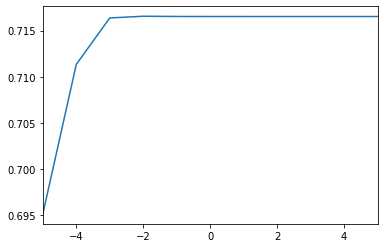

In [22]:
scores = score_lr(X_train, y_train)
scores.plot()

In [23]:
print_best_lr_score(scores)

Наилучшее значение показателя AUC-ROC достигается при C = 0.01 и равно 0.72.


In [24]:
#Удаление категориальных признаков не повлияло на качество предсказания.
#Получается, что в предыдущей модели эти признаки никак не влияли на результат предсказания, модель смогла распознать этот шум.

In [25]:
#3. На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду.
unique_heroes = np.unique(train[hero_columns].values.ravel())
N = max(unique_heroes)
print(f"Число уникальных героев в train: {len(unique_heroes)}. Максимальный ID героя: {N}.")

Число уникальных героев в train: 108. Максимальный ID героя: 112.


In [26]:
#4. Воспользуемся подходом "мешок слов" для кодирования информации о героях.
def get_pick(data: pd.DataFrame) -> pd.DataFrame:
    X_pick = np.zeros((data.shape[0], N))

    for i, match_id in enumerate(data.index):
        for p in range(1, 6):
            X_pick[i, data.loc[match_id, f"r{p}_hero"] - 1] = 1
            X_pick[i, data.loc[match_id, f"d{p}_hero"] - 1] = -1

    return pd.DataFrame(X_pick, index=data.index, columns=[f"hero_{i}" for i in range(N)])

X_pick = get_pick(train)
X_pick.head()

,hero_0,hero_1,hero_2,hero_3,hero_4,hero_5,hero_6,hero_7,hero_8,hero_9,...,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
X_train = pd.concat([X_train, X_pick], axis=1)

C=1e-05
Score: 0.699
Time elapsed: 0:00:17.288686

C=0.0001
Score: 0.725
Time elapsed: 0:00:24.603744

C=0.001
Score: 0.746
Time elapsed: 0:00:16.010612

C=0.01
Score: 0.752
Time elapsed: 0:00:28.059339

C=0.1
Score: 0.752
Time elapsed: 0:00:33.713705

C=1.0
Score: 0.752
Time elapsed: 0:00:34.745687

C=10.0
Score: 0.752
Time elapsed: 0:00:56.633447

C=100.0
Score: 0.752
Time elapsed: 0:00:37.826965

C=1000.0
Score: 0.752
Time elapsed: 0:00:37.526327

C=10000.0
Score: 0.752
Time elapsed: 0:00:32.206094

C=100000.0
Score: 0.752
Time elapsed: 0:00:40.199637



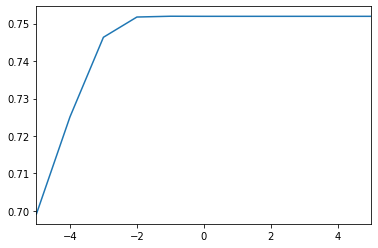

In [28]:
#5. Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации.
scores = score_lr(X_train, y_train)
scores.plot()

In [29]:
print_best_lr_score(scores)

Наилучшее значение показателя AUC-ROC достигается при C = 0.10 и равно 0.75.


In [30]:
#После добавления "мешка слов" по героям качество заметно улучшилось.
#Это объясняется тем, что вместо отсутствия данных о героях или случайного шума из id мы имеем
#осмысленную разреженную матрицу для построения предсказания.

In [31]:
#6. Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей
#(лучшей с точки зрения AUC-ROC на кросс-валидации).
model = LogisticRegression(C=0.1, random_state=42)
model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
test = pd.read_csv("C:/Users/Юлия Витковская/Desktop/features_test.csv", index_col="match_id")
test.fillna(0, inplace=True)

In [34]:
X_test = pd.DataFrame(scaler.transform(test), index=test.index, columns=test.columns)
X_test.drop(cat_columns, axis=1, inplace=True)
X_test = pd.concat([X_test, get_pick(test)], axis=1)
X_test.head()

,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,r2_xp,...,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,
6,-2.528200,0.501314,-0.230161,-0.126909,-0.357459,-0.537757,1.017574,0.291758,-0.332256,-0.011207,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-2.527214,-1.297676,-1.195592,-1.245180,-1.131661,-0.537757,-0.578083,0.291758,0.578881,0.008600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,-2.525688,-1.297676,-0.851426,-0.732370,-1.131661,-0.537757,-0.578083,1.893320,-1.243393,-1.383288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13,-2.521671,-0.398181,-0.927319,-0.527677,-1.131661,0.968527,1.017574,1.092539,-1.243393,-0.931329,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
16,-2.520369,0.501314,0.045173,-1.049106,-0.799860,-0.537757,-0.578083,0.291758,1.490017,0.925122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
preds = pd.Series(model.predict_proba(X_test)[:, 1])
preds.describe()

count    17177.000000
mean         0.517023
std          0.220954
min          0.008429
25%          0.346078
50%          0.522133
75%          0.691681
max          0.996371
dtype: float64

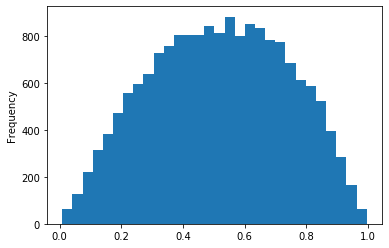

In [36]:
preds.plot.hist(bins=30)